<a href="https://colab.research.google.com/github/webbigdata-jp/python_sample/blob/main/Stable_Diffusion_repeat_sampe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 連続して複数のイラストを描けるようになるためのColab

本Colabではシードを再利用してStable Diffusionで同じ絵描く方法を学びます

## Setup

まず、上段メニューの「ランタイム」を選択し「ランタイムのタイプを変更」より「ハードウェアアクセラレータ」に「GPU」を選んで「保存」を押してください。GPUはAIを効率的に動かすために必要なハードウェアです。

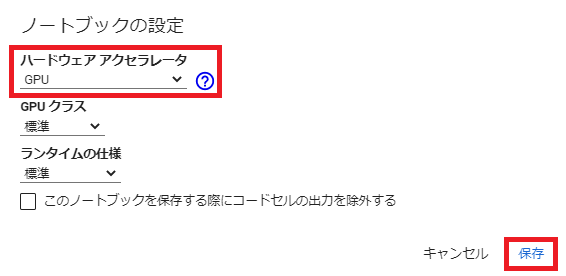

### モデルのダウンロード
動かすために必要なライブラリのインストールします

In [ ]:
%%capture
%%shell
#@markdown ライブラリのインストール
#!pip install git+https://github.com/huggingface/diffusers.git
pip install diffusers==0.12
pip install transformers scipy ftfy
pip install "ipywidgets>=7,<8"
#from google.colab import output
#output.enable_custom_widget_manager()

このデモはStable Diffusionの学習済モデルを使用します。  

以下のセルを実行すると約5Gバイトのモデルをダウンロードするので数分かかります。ライセンス等の使用条件を[配布サイト](https://huggingface.co/spaces/CompVis/stable-diffusion-license)で確認した上で実行してください。

In [ ]:
%%capture
%%shell
#@markdown セットアップ


MODEL="runwayml/stable-diffusion-v1-5"

mkdir -p $MODEL
cd $MODEL
wget https://huggingface.co/${MODEL}/raw/main/model_index.json

mkdir vae
cd vae
wget https://huggingface.co/${MODEL}/raw/main/vae/config.json
wget https://huggingface.co/${MODEL}/resolve/main/vae/diffusion_pytorch_model.bin

cd ..

mkdir unet
cd unet
wget https://huggingface.co/${MODEL}/raw/main/unet/config.json
wget https://huggingface.co/${MODEL}/resolve/main/unet/diffusion_pytorch_model.bin
cd ..

mkdir tokenizer
cd tokenizer
wget https://huggingface.co/${MODEL}/raw/main/tokenizer/merges.txt
wget https://huggingface.co/${MODEL}/raw/main/tokenizer/special_tokens_map.json
wget https://huggingface.co/${MODEL}/raw/main/tokenizer/tokenizer_config.json
wget https://huggingface.co/${MODEL}/raw/main/tokenizer/vocab.json
cd ..

mkdir text_encoder
cd text_encoder
wget https://huggingface.co/${MODEL}/raw/main/text_encoder/config.json
wget https://huggingface.co/${MODEL}/resolve/main/text_encoder/pytorch_model.bin
cd ..

mkdir scheduler
cd scheduler
wget https://huggingface.co/${MODEL}/raw/main/scheduler/scheduler_config.json
cd ..

mkdir feature_extractor
cd feature_extractor
wget https://huggingface.co/${MODEL}/raw/main/feature_extractor/preprocessor_config.json
cd ..

mkdir safety_checker
cd safety_checker
wget https://huggingface.co/${MODEL}/resolve/main/safety_checker/pytorch_model.bin
wget https://huggingface.co/${MODEL}/raw/main/safety_checker/config.json



cd ..
cd ..

### Stable Diffusionでイラストを生成するためのスクリプトの実行

In [ ]:
%%capture
#@markdown スクリプトの実行

import torch
from diffusers import StableDiffusionPipeline


device = "cuda"
model_id = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    revision="fp16",
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True, 
    local_files_only=True
).to(device)

from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

num_images = 4
width = 512
height = 512

generator = torch.Generator(device=device)

latents = None
seeds = []
for _ in range(num_images):
    # Get a new random seed, store it and use it as the generator state
    seed = generator.seed()
    seeds.append(seed)
    generator = generator.manual_seed(seed)
    
    image_latents = torch.randn(
        (1, pipe.unet.in_channels, height // 8, width // 8),
        generator = generator,
        device = device
    )
    latents = image_latents if latents is None else torch.cat((latents, image_latents))
    
# latents should have shape (4, 4, 64, 64) in this case
latents.shape


## 画像の生成

それでは「フェルメール風のラブラドール」をプロンプトに指定して画像を生成してみましょう。

In [ ]:
prompt = "Labrador in the style of Vermeer"

with torch.autocast("cuda"):
    images = pipe(
        [prompt] * num_images,
        guidance_scale=7.5,
        latents = latents,
    ).images

image_grid(images, 2, 2)

何番目が良いですか？  
Colabは実行するスクリプトを変更する事でスクリプトの動作を変える事ができます。  
同じシードを使用すると、同じ結果が得られるはずです。

In [ ]:
select_image = 1
seed = seeds[select_image] 
seed
images[select_image].save("selected_image" + str(seed ) + ".png")

同じシードと同じプロンプトを使用して画像生成を繰り返すと、前と同じ画像が得られるはずです。

In [ ]:
generator.manual_seed(seed)

latents = torch.randn(
    (1, pipe.unet.in_channels, height // 8, width // 8),
    generator = generator,
    device = device
)

with torch.autocast("cuda"):
    image = pipe(
        [prompt] * 1,
        guidance_scale=7.5,
        latents = latents,
    ).images
    
image[0]

できました！

これで、同じシードを維持しながらプロンプトを微調整することができます。 そして、構造は似ているけれども内容やスタイルが異なる画像を作成できます。

例えば：
フェルメール風のテリア

In [ ]:
prompt = "Terrier in the style of Vermeer"

with torch.autocast("cuda"):
    image = pipe(
        [prompt] * 1,
        guidance_scale=7.5,
        latents = latents,
    ).images
    
image[0]

ゴッホ風のラブラドール

In [ ]:
prompt = "Labrador in the style of Van Gogh"

with torch.autocast("cuda"):
    image = pipe(
        [prompt] * 1,
        guidance_scale=7.5,
        latents = latents,
    ).images
    
image[0]

フェルメール風のピエロ

In [ ]:
prompt = "Clown in the style of Vermeer"

with torch.autocast("cuda"):
    image = pipe(
        [prompt] * 1,
        guidance_scale=7.5,
        latents = latents,
    ).images
    
image[0]

### GoogleDriveとの連携

In [ ]:
%%capture
#@markdown Googleドライブ連携
from google.colab import drive
drive.mount('/content/drive')